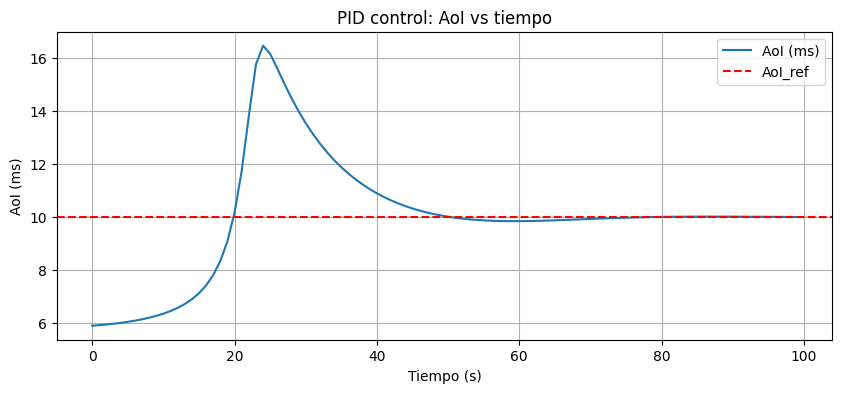

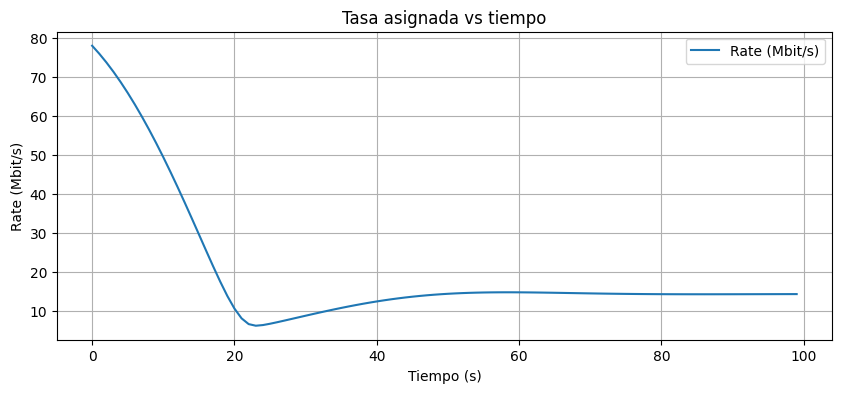

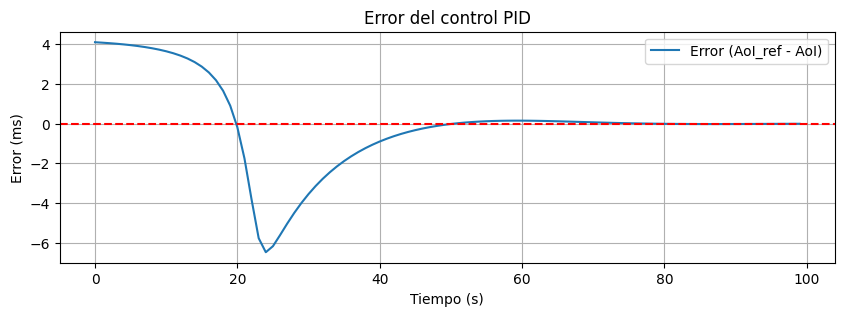

>> [Showing stats]
   AoI_mean_ms  AoI_std_ms  Rate_mean_mbit  Rate_std_mbit
0    10.000212    2.282733       20.275142      17.251141


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd



# Params
T_sim = 100         # duración simulación (s)
dt = 1.0             # periodo de control (s)
N = int(T_sim / dt)

AoI_ref = 10.0     # objetivo E2E(ms)
Twait = 5.0             # latencia media -> cola (ms)
L = 9000        
R = 80.0              # tasa inicial (Mbit/s)
R_min, R_max = 1, 20000

# PID parmas
Kp, Ki, Kd = -0.4, -0.05, -0.02     ## Signos negativos + Delay que el obj -> error negativo -> -1 incrementar rate 
integral, prev_error = 0, 0


times, AoI_vals, R_vals, error_vals = [], [], [], []

def latency(R):
    """Modelo simple de latencia"""
    # Tw_var = np.random.normal(0,2)
    # L_var = np.random.normal(-0.001*L,0)
    L_var = 0
    Tw_var = 0
    tx_delay_ms = ((L + L_var)* 8 / (R * 1e6)) * 1e3
   
    return  Twait + Tw_var + tx_delay_ms 


for i in range(N):
    t = i * dt
    AoI = latency(R)               
    error = AoI_ref - AoI          # Error -> para el PID controller
    integral += error * dt
    derivative = (error - prev_error) / dt
    prev_error = error

    # Control PID
    R += Kp*error + Ki*integral + Kd*derivative
    R = np.clip(R, R_min, R_max)

    
    times.append(t)
    AoI_vals.append(AoI)
    R_vals.append(R)
    error_vals.append(error)

# --- Gráficas ---
plt.figure(figsize=(10,4))
plt.plot(times, AoI_vals, label="AoI (ms)")
plt.axhline(AoI_ref, ls='--', c='r', label="AoI_ref")
plt.title("PID control: AoI vs tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("AoI (ms)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(times, R_vals, label="Rate (Mbit/s)")
plt.title("Tasa asignada vs tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("Rate (Mbit/s)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(times, error_vals, label="Error (AoI_ref - AoI)")
plt.axhline(0, ls='--', c='r')
plt.title("Error del control PID")
plt.xlabel("Tiempo (s)")
plt.ylabel("Error (ms)")
plt.grid(True)
plt.legend()
plt.show()

print(">> [Showing stats]")
df = pd.DataFrame({ "time_s": times, "AoI_ms": AoI_vals, "rate_mbit": R_vals, "error_ms": error_vals })
stats = { "AoI_mean_ms": df["AoI_ms"].mean(), "AoI_std_ms": df["AoI_ms"].std(), "Rate_mean_mbit": df["rate_mbit"].mean(), 
         "Rate_std_mbit": df["rate_mbit"].std() } 
stats_df = pd.DataFrame([stats])
print(stats_df)

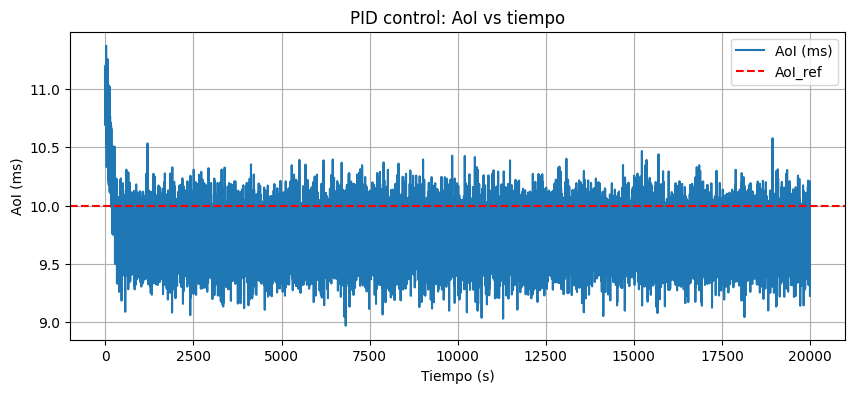

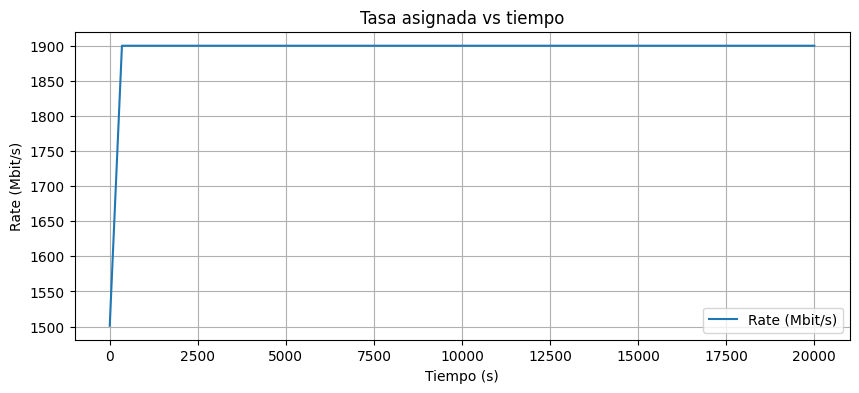

Final R: 1900.0
AoI final: 9.22688211585482


In [580]:
import numpy as np
import matplotlib.pyplot as plt
from simple_pid import PID
import pandas as pd

# --- Parámetros de simulación ---
T_sim = 20000
dt = 1.0
N = int(T_sim / dt)

AoI_ref = 10.0          # objetivo E2E (ms)
Twait = 5.0             # retardo medio fijo (ms)
L = 9e6                 # tamaño del paquete (bits)
R = 1500.0                # tasa inicial (Mbit/s)
R_min, R_max = 1, 1900.0

# --- PID ---
pid = PID(Kp=1, Ki=0.05, Kd=0.02, setpoint=AoI_ref)
pid.sample_time = dt


# --- Buffers ---
times, AoI_vals, R_vals, error_vals = [], [], [], []

def latency(R):
    """Modelo hiperbólico simple: AoI = Twait + L/R"""
    tx_delay_ms = (L / (R * 1e6)) * 1e3
    noise = np.random.normal(0, 0.2)
    return Twait + tx_delay_ms + noise

# --- Bucle principal ---
for i in range(N):
    t = i * dt
    AoI = latency(R)

    # PID inverso porque AoI↓ cuando R↑
    control = -pid(AoI)
    R += control
    R = np.clip(R, R_min, R_max)

    error = AoI_ref - AoI

    times.append(t)
    AoI_vals.append(AoI)
    R_vals.append(R)
    error_vals.append(error)

# --- Gráficas ---
plt.figure(figsize=(10,4))
plt.plot(times, AoI_vals, label="AoI (ms)")
plt.axhline(AoI_ref, ls='--', c='r', label="AoI_ref")
plt.title("PID control: AoI vs tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("AoI (ms)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(times, R_vals, label="Rate (Mbit/s)")
plt.title("Tasa asignada vs tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("Rate (Mbit/s)")
plt.grid(True)
plt.legend()
plt.show()

print("Final R:", R)
print("AoI final:", AoI)


### From medium page

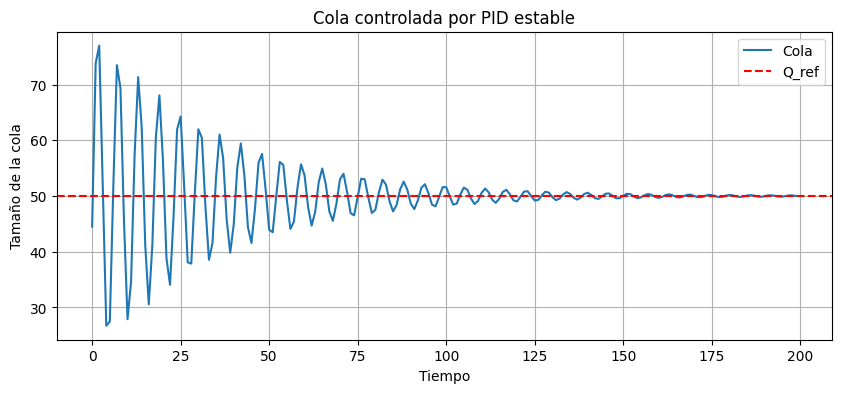

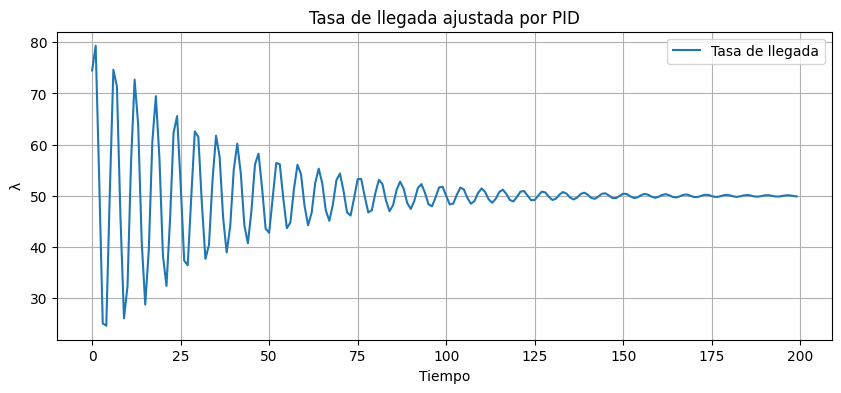

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
T_sim = 200
Q_ref = 50.0
mu = 50.0
Q = 20.0
lambda_rate = 40.0
lambda_min, lambda_max = 0, 100

# PID discreto
Kp = 1
Ki = 0.05
Kd = 0.1  # opcional
integral = 0
prev_error = 0

queue_history = []
lambda_history = []

dt = 1.0

for t in range(T_sim):
    error = Q_ref - Q
    integral += error * dt
    derivative = (error - prev_error)/dt
    prev_error = error

    # PID
    control = Kp*error + Ki*integral + Kd*derivative

    # Limitar cambio de lambda
    lambda_rate = np.clip(lambda_rate + control, lambda_min, lambda_max)



    # Evolución de la cola
    Q = Q + lambda_rate - mu
    Q = max(Q, 0)

    queue_history.append(Q)
    lambda_history.append(lambda_rate)

# Graficas
plt.figure(figsize=(10,4))
plt.plot(queue_history, label="Cola")
plt.axhline(Q_ref, ls='--', c='r', label="Q_ref")
plt.title("Cola controlada por PID estable")
plt.xlabel("Tiempo")
plt.ylabel("Tamaño de la cola")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(lambda_history, label="Tasa de llegada")
plt.title("Tasa de llegada ajustada por PID")
plt.xlabel("Tiempo")
plt.ylabel("λ")
plt.grid(True)
plt.legend()
plt.show()


In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

init = 0
end = -1
# Cargar archivo
file = pd.read_csv("xappsensectrl_dels.txt", sep="\t", names=["t","aoi"], header=None)

setpoint_val = 10
# Graficar latencia
plt.figure(figsize=(10,5))
time_s = (file["t"] - file["t"][0]) / 1e6  # microsegundos → segundos
aoi = file["aoi"][init:end]
time_s = time_s[init:end]
plt.plot(time_s, aoi, label="Latency [ms]")
plt.xlabel("Time [s] ")
plt.ylabel("Latency [ms]")
plt.title("Latency vs. time")
plt.axhline(setpoint_val, ls='--', c='r', label="AoI_ref")
plt.grid(True)

# plt.xlim(5)
# plt.ylim(0,50)

print("[Stats]")
print(f" - mean: {np.mean(aoi):.2f} ms")
plt.axhline(np.mean(aoi), ls='--', c='b', label="AoI_meas")
print(f" - std: {np.std(aoi):.2f} ms")
print(f" - min: {np.min(aoi):.2f} ms")
print(f" - max: {np.max(aoi):.2f} ms")

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 1000x500 with 0 Axes>

[Stats]
 - mean: 4704.26 Mbps
 - std: 1593.487063189969


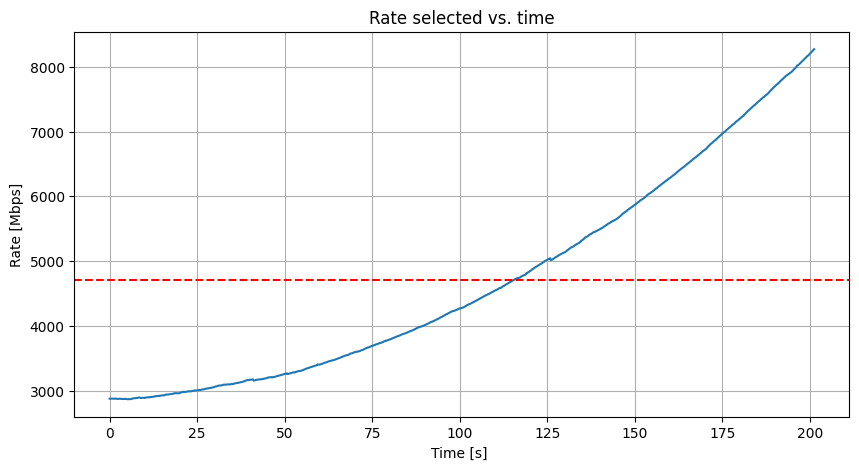

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

init = 0
# Cargar archivo
file = pd.read_csv("xappsensectrl_chann.txt", sep="\t", names=["t","aoi"], header=None)

# setpoint_val = 5
# Graficar latencia
plt.figure(figsize=(10,5))
time_s = (file["t"] - file["t"][0]) / 1e6  # microsegundos → segundos
aoi = file["aoi"][init:]
time_s = time_s[init:]
plt.plot(time_s, aoi, label="Latency [ms]")
plt.xlabel("Time [s] ")
plt.ylabel("Rate [Mbps]")
plt.title("Rate selected vs. time")

plt.grid(True)

# plt.xlim(5)
# plt.ylim(0,50)

print("[Stats]")
print(f" - mean: {np.mean(aoi):.2f} Mbps")
plt.axhline(np.mean(aoi), ls='--', c='r', label="AoI_ref")
print(f" - std: {np.std(aoi)}")
